# Airline Tweets Analysis


In this section, we will go through an example analysis of tweets about airlines. We will cover topics in loading data, manipulating data frames, and statistical analysis/ visualization.

## Introducing the Dataset

- The dataset is from the [Airline tweets sentiment dataset](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?resource=download), which uses tweets that tag one of several major airlines. The dataset also includes information about the tweet location and time, the airline mentioned, and the sentiment of the tweet.


In [226]:
import numpy as np
import pandas as pd
import os


## 1. Import data:

Skills to include: 
- import multiple files in a directory, (with some simple parsing funtions)
- combine them into a single dataframe (pd.concat)
- write a function called parse_files

##  1.1: Load in a single file 
First, let's load in a single file and take a look at it. 

1. Read in the 'Delta.csv' file. What is the relative filepath for the function?
2. How many rows are there? How many columns?
3. Which columns seem most informative? Are there any extra or redundant columns? 
4. Where is airline represented in the csv file?



In [227]:
## solution
single_airline = pd.read_csv('data/Delta.csv')


It turns out that the airline column is not present in any column, but is in the title of the csv file. Let's extract that information and add it to the dataframe in a column called `airline`. Make sure that it is lower case, and remove the file extension.

In [228]:
## solution
name = 'data/Delta.csv'.split('.')[0].lower()
single_airline['airline'] = name

Now let's make a function `process_file(filepath)` that loads in a file with a filepath and returns the dataframe with the airline column added.

In [272]:
## solution

def process_file(filepath):
    df= pd.read_csv(filepath)
    df['airline'] = filepath.split('/')[1].split('.')[0].lower()
    
    return(df)


Here's another filepath: `'data/US-Airways.csv'` What will be in the airline column in the output? 


In [273]:
process_file('data/US-Airways.csv')

NameError: name 'process_files' is not defined

Let's modify our function to make sure that multi-word airlines have a space rather than a hyphen between words.

In [230]:
## solution
def process_file(filepath):
    df= pd.read_csv(filepath)
    df['airline'] = filepath.split('/')[1].split('.')[0].lower().replace('-',' ')
    
    return(df)


## 1.2 Load in multiple files

Now that we have a function, let's iterate through all of files in the directory. First we will check that the directory has all the same files we expect.


In [274]:
## solution

directory = 'data'
for file in os.listdir(directory):
    print(file)

Delta.csv
United.csv
Southwest.csv
source.rtf
US-Airways.csv
Virgin-America.csv
American.csv


We notice that there is a .txt file in the directory, which isn't a pandas dataframe. This will cause an error in the dataframe processing, so let's use an if statement to filter out the .txt extension.

In [275]:
## solution
directory = 'data'
for file in os.listdir(directory):
    if file.split('.')[1]=='csv':
        print(file)

Delta.csv
United.csv
Southwest.csv
US-Airways.csv
Virgin-America.csv
American.csv


Now we have all of the files we want to have, and we can process them. Let's build a script that processes each file using the function from above and accumulates it into a list of dataframes. As the first step, I substitute in the `process_file` function from above. That results in the error below. What is the error? How do we resolve it?


In [233]:
directory = 'data'
for file in os.listdir(directory):
    if file.split('.')[1]=='csv':
        process_file(file)

FileNotFoundError: [Errno 2] No such file or directory: 'Delta.csv'

Look up the function `os.path.join()`. How can this help dynamically make the filepath? What might be the advantage of this method over string concatenation?

Now, let's update the for-loop to resolve the error from above. 

In [234]:
## solution

directory = 'data'
for file in os.listdir(directory):
    if file.split('.')[1]=='csv':
        process_file(os.path.join(directory,file))

Finally, let's aggregate these into a list and concatenate them into a whole dataframe.

In [235]:
## solution

dflist = []
directory = 'data'
for file in os.listdir(directory):
    if file.split('.')[1]=='csv':
        dflist.append(process_file(os.path.join(directory,file)))
        
df = pd.concat(dflist)
    

Finally, let's take a look at the final data frame.

1. How many rows and columns are there in the total dataframe?
2. How many unique airlines are in the dataset?
3. How many numeric columns are there in the dataset?

In [ ]:
## solution
df.shape

df['airline'].nunique()

df.head()

## 2. Data processing


## 2.1 Nulls

First, let's summarize the null values in the dataset. First, let's look at which columns have null values in them. Which columns have null values? What are some ways that we could deal with them?

**Hint**: `pd.isnull()` may be a good place to start. 

In [236]:
##solution
df.isnull().sum()

Unnamed: 0                          0
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
airline                             0
dtype: int64

We won't be using any of the columns with null values in the analysis, so we don't need to drop any rows from this dataset. 

Let's drop the columns: `tweet_id`, `airline_sentiment_confidence`,`negativereason_confidence`,
`airline_sentiment_gold`,`airline_sentiment_gold`,`tweet_coord`,
`tweet_location`,`user_timezone`

This will make the dataset more manageable for further analysis.

In [237]:
##solution
list(df)
df.drop(['Unnamed: 0','tweet_coord','tweet_id','user_timezone',
         'tweet_created','tweet_location','negativereason_gold',
        'airline_sentiment_gold'],axis=1,inplace=True)

## 2.2 Feature extraction

Now let's do some basic preprocessing on the data. First, let's look at the first few rows of the dataframe. 


In [276]:
df.head(3)

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,name,retweet_count,text,airline,word_count,hashtags,mentions
0,positive,0.6469,NaN,NaN,jaxbra,0,@JetBlue Yesterday on my way from EWR to FLL j...,delta,15,2,1
1,neutral,0.6869,NaN,NaN,Oneladyyouadore,0,@JetBlue I hope so because I fly very often an...,delta,15,0,1
2,neutral,1.0000,NaN,NaN,Oneladyyouadore,0,"@JetBlue flight 1041 to Savannah, GA",delta,6,0,1


Let's do a couple of simple feature extraction on the text data, including the number of words. Let's make four new columns:
1. `word_count`: number of words in each tweet
2. `hashtags` : count the number of '#' symbols
3. `mentions` : count number of '@' symbols
4. one other text feature (your choice): for example number of capital words, links, or punctuation like '!', '?', etc. 


In [239]:
## solution

df['word_count'] = df['text'].str.split(' ').str.len()
## solution

df['hashtags'] = df['text'].str.count('#')

df['mentions'] = df['text'].str.count('@')


# final one your choice

Next steps in text preprocessing would often use tokenization or vectorization on tweets, to convert the words themselves to numerical data for preprocessing. If you are interested, check out the Python Text Analysis workshop! 


## 2.3 Subset tweets

How many sentiment types are there in the dataframe? 

For our exploratory analysis, let's start by looking just at postive/negative tweets.

1. Subset the dataframe
2. What proportion of the tweets have a positive sentiment?


What is the condition that we would use to subset the dataframe? Subset the dataframe for non-neutral tweets and save it to a dataframe called `pos_neg_df`

In [240]:
##solution

df['airline_sentiment'].unique()
pos_neg_df = df.loc[(df['airline_sentiment']!= 'neutral'),:]

The `airline_sentiment` column has the terms `positive` and `negative` in it. Let's change them to a numerical column, where 1 = positive, and 0 = negative.

In [241]:
## solution
pos_neg_df.loc[pos_neg_df['airline_sentiment']=='positive','airline_sentiment'] = 1
pos_neg_df.loc[pos_neg_df['airline_sentiment']=='negative','airline_sentiment'] = 0

/Users/emilygrabowski/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


# 3 Exploratory analysis

##  3.1 Most common users, most frequent airlines

Let's look at the users tweeting at the airlines. 

1. How many unique users are there in the dataset? 
2. Who tweeted the most about airlines in this dataset? (**Hint**: consider df.value_counts())
3. Choose one of the users with the top five most tweets. Which airline are they tweeting about?

**Hint**: Users are recorded in the `name` column


In [242]:
## solution

pos_neg_df['name'].unique()
users = pos_neg_df.value_counts('name')
pos_neg_df.loc[pos_neg_df['name'] == 'otisday','airline'].values[0]

'american'

This format doesn't give a great idea of the overall distribution of the data. Let's plot this data in a histogram using `pd.plot`. How would I add a title and x-axis label to the plot?

<AxesSubplot:ylabel='Frequency'>

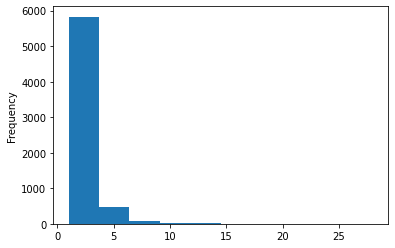

In [222]:
## solution
users.plot(kind='hist')

##  3.2 Most common negative reasons for tweets

Now let's look at the `negativereasons` column. This column summarizes what topic the user is tweeting about for negative tweets. 

1. How many tweets are about each reason? Sort these from lowest frequency to highest frequency. Which reason is the most common, and which is the least?
2. Make a bar plot from the frequency counts. Add a title and a y-label. 

**Bonus**: Add additional customizations to the plot


<AxesSubplot:xlabel='negativereason'>

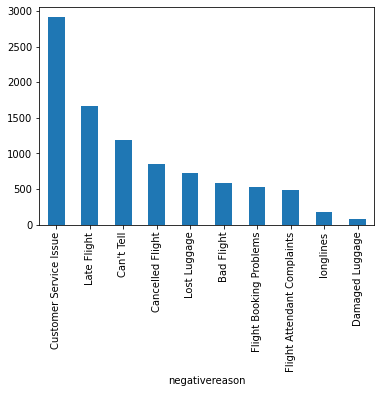

In [278]:
## Solution

reasons = pos_neg_df.value_counts('negativereason')
reasons.plot(kind = 'bar')


## 3.3 Are negative tweets longer than positive tweets?

Let's take a look at the negative and positive tweets. We are interested in the question of whether negative tweets are longer than positive tweets. Let's test this with a t-test.

1. Subset the data into positive and negative tweets
2. Select the `word_count` column
3. Calculate the mean word count for each column. Which mean is higher?
3. Use a t-test to compare the two sets of values from (2). What is the p-value of the result? 
4. Plot a histogram layer for both positive and negative tweet word counts. What do you notice about the distribution?

**Hint**: Refer to the statsmodels notebook from Day 3 for an example!

In [246]:
##solution
res = sm.stats.ttest_ind(pos_neg_df.loc[pos_neg_df['airline_sentiment']==0,'word_count'],
                         pos_neg_df.loc[pos_neg_df['airline_sentiment']==1,'word_count'])
res

#pos_neg_df.loc[pos_neg_df['airline_sentiment']==0,'word_count'].plot(kind='hist')
#pos_neg_df.loc[pos_neg_df['airline_sentiment']==1,'word_count'].plot(kind='hist')

(39.63668145325772, 0.0, 11539.0)

## 3.4 Linear regression of tweet length

Let's use a linear regression to look at other predictors of tweet length. 
Steps:
1. Select the numeric columns and save it as `X` from the dataframe (except wordcount)
2. Select word_count column and save as `y`
3. Set up a linear regression and fit it to the data
4. Interpret the model summary


**Bonus**: How many lines of code did it take? Can you shorten it?

In [277]:
## solution

import statsmodels.api as sm
X = np.array(pos_neg_df[['airline_sentiment','airline_sentiment_confidence','retweet_count','hashtags','mentions']],dtype=float)

y = np.array(pos_neg_df['word_count'],dtype=float)

model=sm.OLS(y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.889
Model:                            OLS   Adj. R-squared (uncentered):              0.889
Method:                 Least Squares   F-statistic:                          1.850e+04
Date:                Fri, 29 Apr 2022   Prob (F-statistic):                        0.00
Time:                        09:40:46   Log-Likelihood:                         -38157.
No. Observations:               11541   AIC:                                  7.632e+04
Df Residuals:                   11536   BIC:                                  7.636e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -4.3082      0.151    -28.486      0.000      -4.605      -4.012
x2            17.4968      0.183     95.719      0.000      17.138      17.855
x3             0.1355      0.080      1.692      0.091      -0.022       0.292
x4            -0.0080      0.093     -0.085      0.932      -0.191       0.175
x5             2.7815      0.145     19.242      0.000       2.498       3.065
==============================================================================
Omnibus:                      109.500   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.136
Skew:                          -0.218   Prob(JB):                     3.30e-24
Kurtosis:                       2.815   Cond. No.                         5.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Next Steps

This notebook took us through importing multiple csv files, data manipulation, and some basic visualizations and analysis of data. If you were working on this dataset, what would you potentially do next? It could be either an analysis, a new feature to include, a visualization that might help represent the data, etc.